In [2]:
import pandas as pd
from methods import *
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

'''
# Ensure NLTK resources are downloaded (only needs to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
'''

src = "https://www.debates.org/voter-education/debate-transcripts"
debateData = {}


In [ ]:
urlsTemp = urlExtractor(src)[10:57] # hardcoded way to get the urls that specifically pertain to the transcripts of the debates
urls = []
for url in urlsTemp:
    urls.append("https://www.debates.org" + url)

In [ ]:
# For each article URL, call the getArticleData and add it to a dictionary
for article_url in urls:
    tempData = getArticleData(article_url)
    debateData[formatDate(tempData[0])] = {"text" :tempData[1], "source" : article_url}

In [ ]:
# SENTIMENT ANALYSIS
sentDict = {}
# for every article, compute the sentiment by word, sentence, and document.
id = 0
for date,val in debateData.items():
    scores = overall_sentiment(val.get("text"))
    sentDict[id] = {"source" : val.get("source"), 
                    "date" : date,
                    "by word (sum)" : scores[0] * 100,
                    "by sentence (sum)": scores[1] * 100}
    id += 1

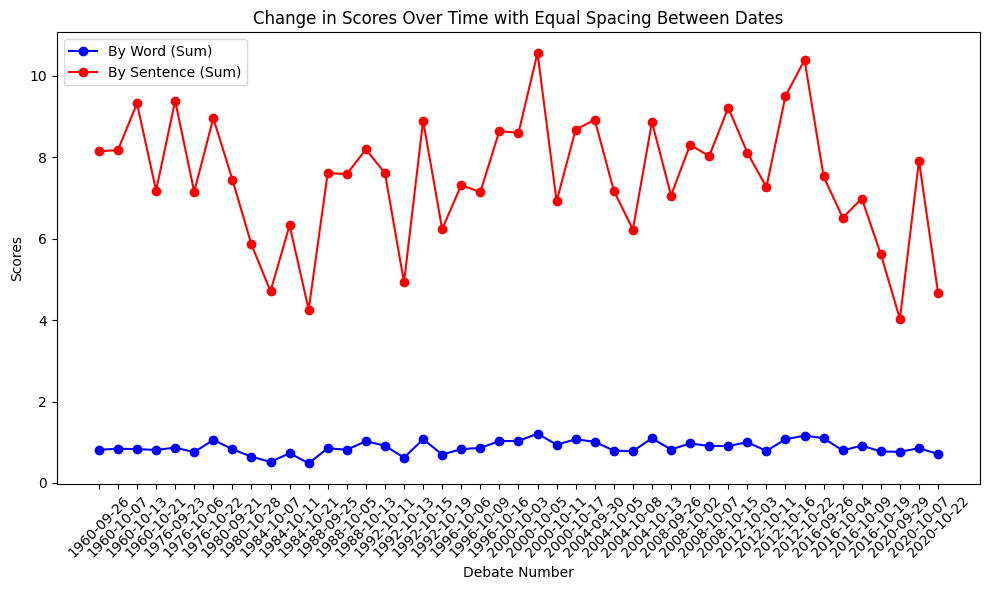

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(sentDict, orient='index')
df['date'] = pd.to_datetime(df['date'])

# Sort DataFrame by date
df = df.sort_values(by='date')

# Plotting
plt.figure(figsize=(10, 6))

# Plot by word (sum)
plt.plot(range(len(df)), df['by word (sum)'], marker='o', linestyle='-', color='b', label='By Word (Sum)')

# Plot by sentence (sum)
plt.plot(range(len(df)), df['by sentence (sum)'], marker='o', linestyle='-', color='r', label='By Sentence (Sum)')

# Set the labels and title
plt.xlabel('Debate Number')
plt.ylabel('Scores')
plt.title('Change in Scores Over Time with Equal Spacing Between Dates')
plt.legend()

# Set x-ticks to the number of entries and replace with date labels
plt.xticks(range(len(df)), df['date'].dt.strftime('%Y-%m-%d'), rotation=45)

# Show plot
plt.tight_layout()
plt.show()

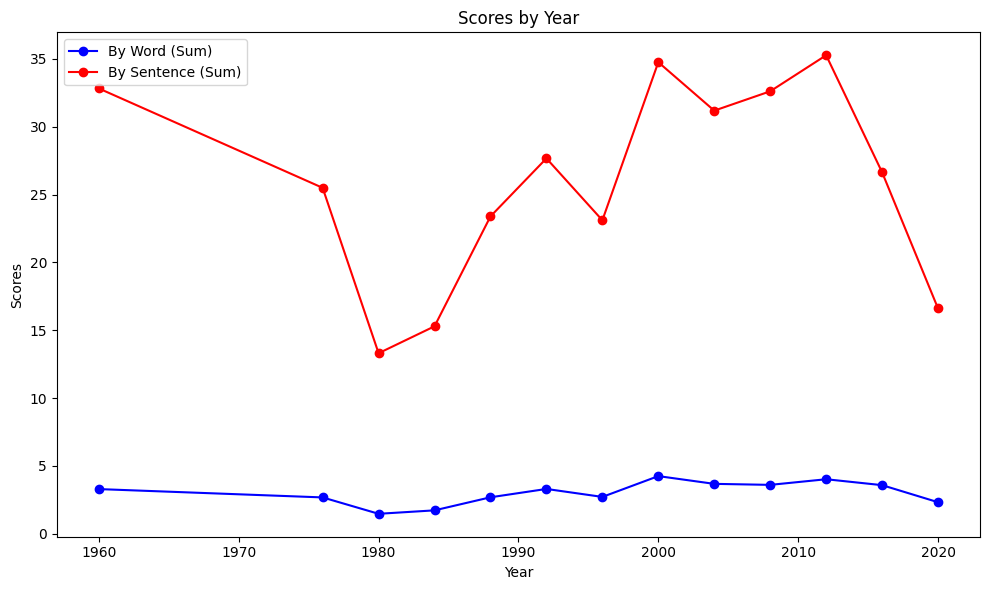

In [ ]:
# Extract year from date and add it as a new column
df['year'] = df['date'].dt.year

# Group by year and sum the scores
yearly_sum = df.groupby('year').agg({'by word (sum)': 'sum', 'by sentence (sum)': 'sum'})

# Plotting
plt.figure(figsize=(10, 6))

# Plot by word (sum) for each year
plt.plot(yearly_sum.index, yearly_sum['by word (sum)'], marker='o', linestyle='-', color='b', label='By Word (Sum)')

# Plot by sentence (sum) for each year
plt.plot(yearly_sum.index, yearly_sum['by sentence (sum)'], marker='o', linestyle='-', color='r', label='By Sentence (Sum)')

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Scores')
plt.title('Scores by Year')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()